In [13]:
from typing import Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import drdmannturb.fluctuation_generation.gaussian_random_fields as grf

# For cleanliness
ArrayType = Union[np.ndarray, float]


# So, phi_ij (k1, k2) is given by equation 1.
# phi_ij(k1, k2) = (E(k) / (\pi k)) * (delta_ij - (k_i * k_j) / (k^2))

# Then, we want to substitute kappa in for k in E(k), NB psi is a constant at this point.

# k_bold = (k1, k2)

# NB 0 < psi < pi/2

"""
Input Parameters
"""

# Physical parameters

L_2D = 15000 # Length scale of the domain
z_i = 500 # Height of the domain
c = 1.0 # Scaling factor NOTE: What should this actually be?
psi = 43 # IN DEGREES; anisotropy angle parameter, 0 < psi < 90 in degrees

# Grid parameters

N1 = 1024 # Number of grid points in x direction
N2 = 256 # Number of grid points in y direction

dx = 1/2 # Grid spacing in x direction
dy = 1/2 # Grid spacing in y direction

In [21]:

def compute_Cij_squared(
        k1, k2, i, j, L1, L2, psi, L_2D, z_i, c
):
    leading_factor = 2 * np.pi / L1

    def compute_kappa(k1, k2, psi):
        """
        Compute kappa (equation 4)
        """

        return np.sqrt(2 * ((k1**2 * np.cos(psi)**2) + (k2**2 * np.sin(psi)**2)))

    def compute_E(kappa):
        """
        Compute the energy spectrum
        """

        energy_spectrum = ( 
            (c * (kappa**3)) \
            / (((L_2D**(-2)) + (kappa**2))**(7/3))
        )

        attenuation_factor = 1 / (1 + (kappa * z_i)**2)

        return energy_spectrum * attenuation_factor

    def compute_phi_ij(k1, k2, i, j, psi):
        """
        Compute the spectral tensor component phi_ij at wave vector k1,k2
        """

        # TODO: Right now we're just going to use k = |k_bold|. If it's weird, we try replacing all
        #       k with kappa.

        kappa = compute_kappa(k1, k2, psi)

        if np.isclose(kappa, 0.0):
            return 0.0

        E = compute_E(kappa)

        delta_ij = 1 if i == j else 0

        k_sq = k1**2 + k2**2

        if np.isclose(k_sq, 0.0):
            return 0.0
        
        trailing_factor = 0.0
        if i == 0 and j == 0:
            trailing_factor = delta_ij - ((k1**2) / k_sq)
        elif i == 1 and j == 1:
            trailing_factor = delta_ij - ((k2**2) / k_sq)
        else:
            trailing_factor = delta_ij - ((k1 * k2) / k_sq)

        return (E / (np.pi * kappa)) * trailing_factor

    # Build integrand
    def integrand(k2p, k1, k2, i, j):

        # Compute phi_ij(k1, k2p)
        phi_ij = compute_phi_ij(k1, k2p, i, j, psi)

        # Compute sinc^2
        sinc_term = np.sinc(
            (k2 - k2p) * L2 / 2
        )

        return phi_ij * sinc_term

    # integral bounds
    k2p_min = k2 - (2 * np.pi / L2)
    k2p_max = k2 + (2 * np.pi / L2)

    result = integrate.quad(
        integrand, k2p_min, k2p_max, args=(k1, k2, i, j)
    )

    # print("Integral result: ", result[0])
    # print("Integral error: ", result[1])

    return result[0] * leading_factor


In [22]:
def generate_wind_field(L_2D, z_i, c, psi, N1, N2, dx, dy):
    """
    Generate the wind field
    """

    N1, N2 = int(N1), int(N2)   

    L1 = N1 * dx
    L2 = N2 * dy

    m1 = np.arange(-N1//2, N1//2)
    m2 = np.arange(-N2//2, N2//2)

    k1 = m1 * 2 * np.pi / L1
    k2 = m2 * 2 * np.pi / L2

    k1_grid, k2_grid = np.meshgrid(k1, k2, indexing='ij')

    C = np.zeros((2,2,N1,N2), dtype=np.complex128)

    for i in range(2):
        for j in range(2):
            for idx1 in range(N1):
                for idx2 in range(N2):
                    C[i,j,idx1,idx2] = compute_Cij_squared(
                        k1_grid[idx1, idx2],
                        k2_grid[idx1, idx2],
                        i, j,
                        L1, L2, psi, L_2D, z_i, c
                    )

    n = (np.random.normal(0, 1, (2, N1, N2)) 
         + 1j * np.random.normal(0, 1, (2, N1, N2))) / np.sqrt(2)

    u_k = np.zeros((2, N1, N2), dtype=np.complex128)

    for i in range(2):
        for j in range(2):
            u_k[i] += C[i,j] * n[j]

    u = np.real(np.fft.ifft2(u_k, axes=(-2,-1)))

    return u
        


In [23]:
def plot_wind_field(u: np.ndarray, L1: float, L2: float):
    """
    Plot the generated wind field components
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    x = np.linspace(0, L1, u.shape[1])
    y = np.linspace(0, L2, u.shape[2])
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Plot u component
    im1 = ax1.pcolormesh(X, Y, u[0], cmap='RdBu_r')
    ax1.set_title('u component')
    plt.colorbar(im1, ax=ax1)
    
    # Plot v component
    im2 = ax2.pcolormesh(X, Y, u[1], cmap='RdBu_r')
    ax2.set_title('v component')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    return fig

In [24]:
# Set parameters
L1 = 60000  # 60 km
L2 = 15000  # 15 km
N1 = 256
N2 = 64

# Convert psi to radians
psi = np.radians(43)

# Other parameters
L_2D = 15000
c = 1.0
z_i = 500

# Derive dx, dy from domain sizes
dx = L1 / N1
dy = L2 / N2

# Generate wind field correctly
u = generate_wind_field(
    L_2D, z_i, c, psi,
    N1, N2,
    dx, dy
)


/var/folders/xr/kfzp127x60q_6gm1sqwbzts40000gn/T/ipykernel_70982/3819757975.py:41: RuntimeWarning: invalid value encountered in scalar divide
  return (E / (np.pi * kappa)) * (delta_ij - ((k1 * k2) / (np.linalg.norm([k1, k2])**2)))
/var/folders/xr/kfzp127x60q_6gm1sqwbzts40000gn/T/ipykernel_70982/3819757975.py:60: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(
/var/folders/xr/kfzp127x60q_6gm1sqwbzts40000gn/T/ipykernel_70982/3819757975.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perha

Has NaNs? True
Has Infs? False
Array shape: (2, 256, 64)


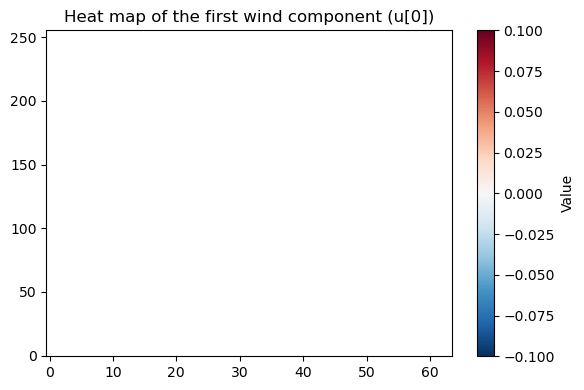

In [26]:
# Check for NaNs and Infs
has_nans = np.isnan(u).any()
has_infs = np.isinf(u).any()

print(f"Has NaNs? {has_nans}")
print(f"Has Infs? {has_infs}")

# Print min and max to see if we have extreme values
if not (has_nans or has_infs):
    # Only compute min/max if no direct NaNs/Infs
    # (or handle them by ignoring with nanmin, nanmax)
    min_val = np.nanmin(u)
    max_val = np.nanmax(u)
    print(f"Array min: {min_val}")
    print(f"Array max: {max_val}")

# Print shape (sanity check)
print(f"Array shape: {u.shape}")

# Example heat map of the first component of u (e.g. u[0])
# to see if there's a localized region of over/underflow.
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(u[0], cmap='RdBu_r', aspect='auto', origin='lower')
ax.set_title("Heat map of the first wind component (u[0])")
plt.colorbar(im, ax=ax, label="Value")
plt.tight_layout()
plt.show()

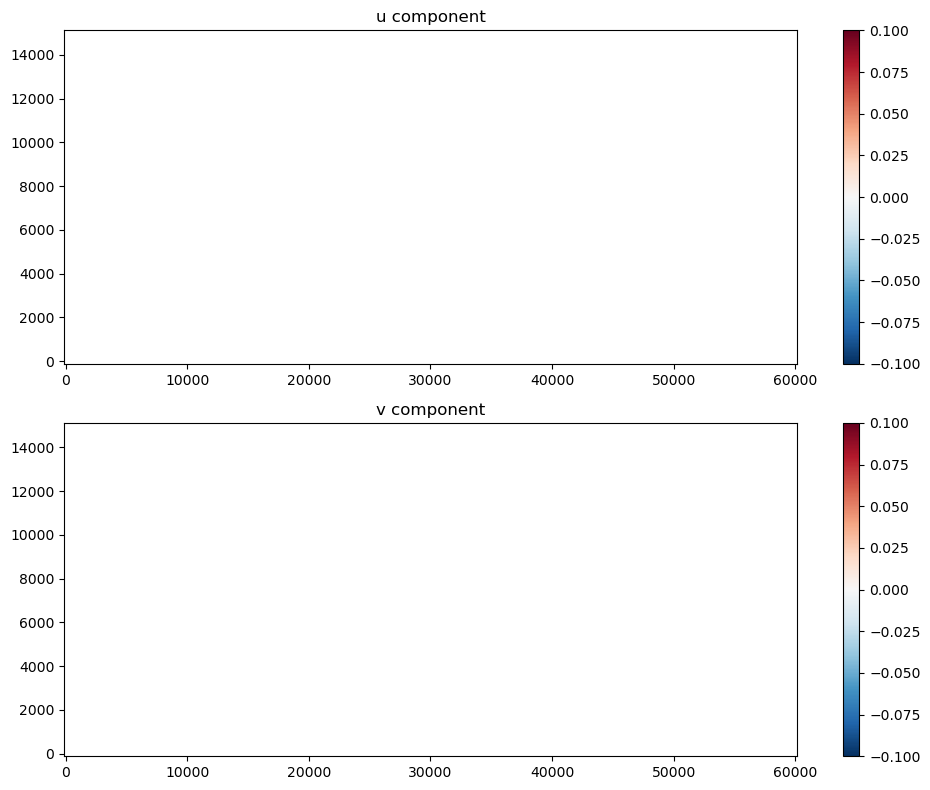

In [25]:

# Now you can plot
fig = plot_wind_field(u, L1, L2)
plt.show()